In [ ]:
import requests
import re
from bs4 import BeautifulSoup
import os.path


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from os import listdir, mkdir, remove
from os.path import isfile, join
from collections import defaultdict, Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('russian')
nltk.download('punkt')
from nltk import word_tokenize

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
morph=MorphAnalyzer()


import gensim
from gensim.models import CoherenceModel, LdaModel, TfidfModel, Word2Vec
from gensim.corpora import Dictionary
from gensim.test.utils import datapath
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 8.2MB 7.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


## Краулер

В следующей клетке представлен код для получения информации об одной публикации при парсинге страницы.

In [ ]:
calendar = {
  'Января':'01',
  'Февраля':'02',
  'Марта':'03',
  'Апреля':'04',
  'Мая':'05',
  'Июня':'06',
  'Июля':'07',
  'Августа':'08',
  'Сентября':'09',
  'Октября':'10',
  'Ноября':'11',
  'Декабря':'12'
}

#конвертация даты в стандартный формат представления
def convert_date(s, calendar = calendar):
  date_split = s.split()[:3]
  date_split[1] = calendar[date_split[1].capitalize()]
  return '.'.join(date_split)

#чтение даты из супа    
def get_date(soup):
  date = soup.find('div', {'class': 'data_news'})
  date = date.find('span').string
  date = str(date)
  return convert_date(date)

#чтение названия публикации из супа
def get_title(soup):
  return soup.title.string

#чтение текста публикации
def get_content(soup):
  content = soup.find('div', {'class': 'poster_content_block'})
  content = content.find_all('p')
  content_l = [el.get_text(strip=True).replace('\xa0', ' ') for el in content]
  return '\n'.join(content_l)

#сбор информации о публикации по заданной ссылке
def get_info(url, website = 'https://mk.tula.ru'):
  full_url = website + url

  #получаем код страницы
  response = requests.get(full_url)
  soup = BeautifulSoup(response.text.replace('\xa0', ' '))
  
  #собираем инфомацию
  date = get_date(soup)
  title = get_title(soup)
  content = get_content(soup)
  
  res_l = ['=====', full_url, date, title, content]
  
  res = '\n'.join(res_l)
  return res

В следующей клетке кода функции для 1) записи информации об одной публикации в файл с полным корпусом, 2) записи в файл информации обо всех статьях на одной странице выдачи.

In [ ]:
def add_res_to_file(url, filename):
  info = get_info(url)
  
  #если файл не существует, создаем его, если существет -- дописываем
  if os.path.isfile(filename):
    with open(filename, 'a') as file:
      file.write(info + '\n')
  else:
    with open(filename, 'w') as file:
      file.write(info + '\n')


def add_all_to_file(page_url, filename, news_class = 'news_container_list_aimg'):
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text)
    
    urls_set = set()
    for e in soup.find_all('a'):
      if 'class' in e.attrs:
        if news_class in e['class']:
          if e['href'] not in urls_set:
            urls_set.add(e['href'])
            add_res_to_file(e['href'], filename)
            #print(e['href'])

В следующей ячейке собираем информацию с заданного количества страниц выдачи.

In [ ]:
def all_pages(page_url, filename, end = 1462):
  for i in range(0, end):
    add_all_to_file(page_url+'?PAGEN_2='+str(i), filename)

mkdir('/content/gdrive/MyDrive/final_project')
all_pages('https://mk.tula.ru/news/', '/content/gdrive/MyDrive/final_project/mktula.txt', end = 100)
with open('mktula.txt', 'a') as file:
    file.write('=====')

Теперь у нас есть необработанный корпус текстов новостных публикаций в фомате *.txt.

## Препроцессинг

В следующей ячейке производим предварительную обработку тектса: удаление специальных символов и пунктуации, лемматизацию, удаление стоп слов.

In [ ]:
#очистка токена от специальных символов
def clean_word_symbols(text, symbols=None):
  text.replace('\xa0', ' ')
  if symbols:
    return text.strip(''.join(symbols))
  else:
    while text and not text[0].isalpha():
      text = text.lstrip(text[0])
    while text and not text[-1].isalpha():
      text = text.rstrip(text[-1])
    return text

#очистка текста от символов
def clean_symbols(text, symbols=None):
  words = [clean_word_symbols(t, symbols=symbols) for t in text.split()]
  return ' '.join(words)

#лемматизация (можно задать, удалять ли сразу стоп-слова)
def lemmatize(text, stopwords=False):
  if stopwords:
    words = [word for word in word_tokenize(text.lower()) if word.isalpha() and not word in sw]
    lems = [morph.parse(word)[0].normal_form for word in words if not word in sw]
    return ' '.join([l for l in lems if len(l)>2])
  else:
    words = [word for word in word_tokenize(text.lower(), language='russian') if word.isalpha()]
    lems = [morph.parse(word)[0].normal_form for word in words if not word in sw]
    return ' '.join([l for l in lems if len(l)>2])

#удаление стоп-слов
def clean_sw(text):
  return ' '.join([word for word in text.split() if not word in sw])

#собираем все выше в одну функцию и возвращаем очищенный текст
def transfrom_text(text, symbols=None, stopwords=True):
  no_sym = clean_symbols(text, symbols=symbols)
  lighter = clean_sw(no_sym)
  lem = lemmatize(lighter, stopwords=stopwords)
  return lem

В следующей ячейке -- чтение и обработка корпуса.

In [ ]:
#чтение корпуса из текстового файла со своевременным разделением информации на категории
def read_corpus(filename):
  res = []
  j=0
  record = []
  with open(filename) as f:
      for l in f:
          if l=="=====\n":
              j = 0
              res.append(record)
              record = []
          elif j < 4:
              j += 1
              record.append(l.strip("\n"))
          else:
              record[-1] += l.strip("\n")
  res.append(record)
  return res

#получение датафрейма корпуса
def corpus_df(filename):
  c = read_corpus(filename)
  df = pd.DataFrame.from_records(c[1:], columns=["link", "date", "title", "text"])
  return df

#конкатенируем название и содержание как полезные текстовые признаки и производим обработку текста
def transform_corpus(df, symbols=None, stopwords=True, date=True):
  if date:
    df_new = pd.DataFrame(columns=['date', 'text'])
    df_new['date'] = df['date'].copy()
  else:
    df_new = pd.DataFrame(columns=['date', 'text'])
  if 'title' and 'text' in df.columns:
    df_new['title_text'] = df.apply(lambda x: ' '.join([x.title, x.text]) if x.title and x.text else '', axis=1)
    df_new['text'] = df_new['title_text'].apply(lambda x: transfrom_text(x, symbols=symbols, stopwords=stopwords))
  else:
    df_new['text'] = df['text'].apply(lambda x: transfrom_text(x, symbols=symbols, stopwords=stopwords))
  return df_new[['text', 'date']]

В следующей ячейке производим чтение, обработку и сохранение в новый файл всего корпуса.

In [ ]:
def one_corpus(filename, path, newdir):
  full_path = join(path, filename)
  try:
    df1 = corpus_df(full_path)
    df1 = transform_corpus(df1)
    new_name = filename[:-4] + '.csv'
    new_path = join(path, newdir, new_name)
    df1.to_csv(new_path, index=False)
    print('success', filename)
  except:
    print('Error', filename)

#mkdir('/content/gdrive/MyDrive/final_project/lem')
one_corpus('mktula.txt', '/content/gdrive/MyDrive/final_project/', 'lem')

success mktula.txt


Теперь у нас есть обработанный корпус в файле формата *.csv с колонками, содержащими дату и текст публикации.

## Модели

Загружаем корпус текстов из файла.

In [ ]:
corpus = pd.read_csv('/content/gdrive/MyDrive/final_project/lem/mktula.csv').text
corpus

0       останки воин красный армия предать земля посёл...
1       два точка шаурм щёкино закрытый сутки коронави...
2       подросток богородицк ожог доставить вертолёт с...
3       туляк продолжать бесплатно раздавать вода жара...
4       тула привезти мощь александр невский фото сего...
                              ...                        
2995    наталия пилюс провести личный приём гражданин ...
2996    полезный привычка вегановый начать утро стакан...
2997    старый тульский аптека серия дизайнерский брош...
2998    снег тульский область идти ночь погода шептать...
2999    пациент уйти тульский больница нижний бельё по...
Name: text, Length: 3000, dtype: object

Интересная и полезная метрика TF-IDF когерентности, которую предложили в исследовании (https://publications.hse.ru/en/articles/192817051) не представлена ни в одной из библиотек pyhton, поэтому я пишу ее сама. Есл обычная метрика когерентности оценивает лишь факт совместной встречаемости определенного топика в документах коллекции, Tf-IDF когерентность опирается на TF-IDF веса слов в том или ином документе.

In [ ]:
#Нам понадобится корпус tf-idf векторов текстов
def tfidf_corpus(bow):
  tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False)
  return tfidf.fit_transform([sum([[t]*q for t, q in bow_doc], []) for bow_doc in bow]).toarray()

#рассчитаем метрику для одной темы
def topic_tfidf_coherence(topic, dictionary, tfidf_corpus, eps=0.01):
  topic_idx = dictionary.doc2idx(topic)
  A = tfidf_corpus[:, topic_idx]
  A = np.log10((np.dot(A.T,A) + 0.01)/ np.sum(A, axis=0))
  return np.sum(A) - np.trace(A)

#найдем TF-IDF когерентность модели как среднее TF-IDF когерентностей топиков
def model_tfidf_coherence(model, bow, dictionary):
  topics = [[term for term, wt in model.show_topic(n, topn=30)] 
                    for n in range(0, model.num_topics)]
  tfidf_c = tfidf_corpus(bow)
  coherences = []
  for topic in topics:
    coherences.append(topic_tfidf_coherence(topic, dictionary, tfidf_c, eps=0.01))
  return np.mean(coherences)

Получаем корпус в виде списка документов, заданных списками слов.

In [ ]:
pc = [[token for token in str(doc).split() if len(token)>2] for doc in corpus]

In [ ]:
len(sum(pc,[]))

316657

Для того чтобы собрать наиболее efficient словарь, проверим, то с какой частотой какое количество слов встречается в корпусе.

Слова, встретившиеся 1 раз составляют 0.41 от всего корпуса
Слова, встретившиеся менее 3 раз составляют 0.55 от всего корпуса
Слова, встретившиеся менее 5 составляют 0.68 от всего корпуса
Слова, встретившиеся более, чем в 10% текстов, составляют 0.0051 от всего корпуса
Слова, встретившиеся более, чем в 20% текстов, составляют 0.0015 от всего корпуса


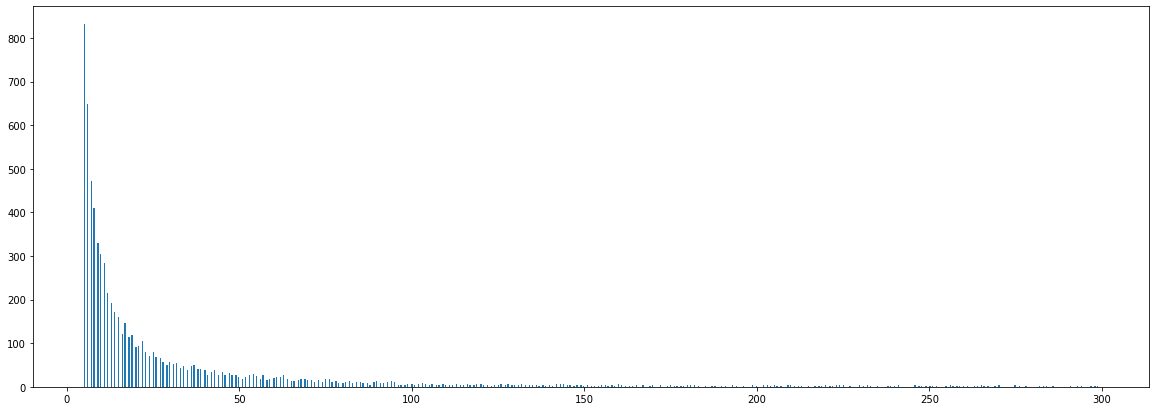

In [ ]:
x = [v for _,v in Counter(sum(pc,[])).items()]
print('Слова, встретившиеся 1 раз составляют {} от всего корпуса'.format(np.round(len([el for el in x if el==1])/len(x),2)))
print('Слова, встретившиеся менее 3 раз составляют {} от всего корпуса'.format(np.round(len([el for el in x if el<3])/len(x),2)))
print('Слова, встретившиеся менее 5 составляют {} от всего корпуса'.format(np.round(len([el for el in x if el<5])/len(x),2)))
print('Слова, встретившиеся более, чем в 10% текстов, составляют {} от всего корпуса'.format(np.round(len([el for el in x if el>300])/len(x),4)))
print('Слова, встретившиеся более, чем в 20% текстов, составляют {} от всего корпуса'.format(np.round(len([el for el in x if el>600])/len(x),4)))

xx = [el for el in x if el>4 and el<=300]
plt.figure(figsize=[20,7])
plt.hist(xx, bins=750)
plt.show()

Больше всего нам нужны слова, которые встречаются не слишком мало и не слишком много. Если слова слишком частотные -- они не помогут информативно разделить топики, если слишком редко -- они тоже не привнесут никакого вклада и будут восприняты моделью как шум, а их очень много, так что для облегчения модели лучше от них избавиться.

In [ ]:
words = [k for k,v in Counter(sum(pc,[])).items() if v>4 and v<=300]
pc_new = [[token for token in doc if token in words] for doc in pc]
d = Dictionary(pc_new)
#d.filter_n_most_frequent(len(set([el for el in x if el<3])))
#d.compactify()

In [ ]:
pc=pc_new

### Bag-of-words

Векторизуем корпус с помощью метода bag-of-words. Обучим модели с разным количеством тем, и для каждой сохраним значение трех метрик качества: двух внешних (когерентность и TF-IDF когерентность) и одной внутренней (перплексия).

In [ ]:
bow = [d.doc2bow(text) for text in pc]
start_n = 10
end_n = 101
step = 6

nums_topics = np.arange(start_n, end_n, step)
coherence_scores, tfidf_scores, perplexities = [], [], []

for n in nums_topics:
  lda = LdaModel(bow, id2word=d, num_topics=n, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
  coherence_scores.append(CoherenceModel(model=lda, corpus=bow, coherence='u_mass').get_coherence()) 
  tfidf_scores.append(model_tfidf_coherence(lda, bow, d))
  perplexities.append(lda.log_perplexity(bow))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
scores = {'bow':{'coh':coherence_scores,
                 'tfidf':tfidf_scores,
                 'perp':perplexities}}

### TF-IDF

Повторим все то же самое, векторизовав тексты методом TF-IDF.

In [ ]:
tfidf_model = TfidfModel(bow)
tfidf = [tfidf_model[doc] for doc in bow]

In [ ]:
start_n = 10
end_n = 101
step = 6

nums_topics = np.arange(start_n, end_n, step)
coherence_scores, tfidf_scores, perplexities = [], [], []

for n in nums_topics:
  lda = LdaModel(tfidf, id2word=d, num_topics=n, 
              random_state=0, chunksize=1740,
              alpha='auto', eta='auto', 
              iterations=500,passes=20, eval_every=None)
  coherence_scores.append(CoherenceModel(model=lda, corpus=tfidf, coherence='u_mass').get_coherence()) 
  tfidf_scores.append(model_tfidf_coherence(lda, bow, d))
  perplexities.append(lda.log_perplexity(tfidf))

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [ ]:
scores['tfidf']={'coh':coherence_scores,
                 'tfidf':tfidf_scores,
                 'perp':perplexities}

## Визуализация

In [ ]:
def visualize_metric(my_x, my_y, title='График зависимости', labels=[], xlabel = 'Количество тем', ylabel='Значение метрики'):
  plt.figure(figsize=(12,6))

  ax = plt.subplot(111)    
  ax.spines["top"].set_visible(False)    
  ax.spines["bottom"].set_visible(False)    
  ax.spines["right"].set_visible(False)    
  ax.spines["left"].set_visible(False) 

  max_score = np.round(max(sum(my_y,[])) + 1, 1)
  min_score = np.round(min(sum(my_y,[])) - .05, 1)

  plt.ylim(min_score, max_score)    
  plt.xlim(0, max(my_x)+1) 

  plt.yticks(np.arange(min_score, max_score, (max_score-min_score)/10), fontsize=14)    
  plt.xticks(my_x, fontsize=14) 

  for y in np.arange(min_score, max_score, 50):    
      plt.plot(np.arange(0, max(my_x)+1), [y] * len(np.arange(0,max(my_x)+1)), "--", lw=0.5, color="black", alpha=0.3) 
      
  plt.tick_params(axis='both', which=False, bottom=False, top=False,    
                  labelbottom=True, labeltop=False, left=False, right=False, labelleft=True)


  for i in range(len(my_y)):
    r, g, b = np.random.randint(100, high=200, size=3)    
    c = (r / 255., g / 255., b / 255.)
    plt.plot(my_x, 
            my_y[i], 
            lw=2.5, color=c, label=labels[i])

  plt.xlabel(xlabel, fontsize=14, labelpad=8)
  plt.ylabel(ylabel, fontsize=14, labelpad=8)
  plt.legend()
  plt.title(title, fontsize=17, loc="center", pad=20) 
  plt.show()

### Когерентность

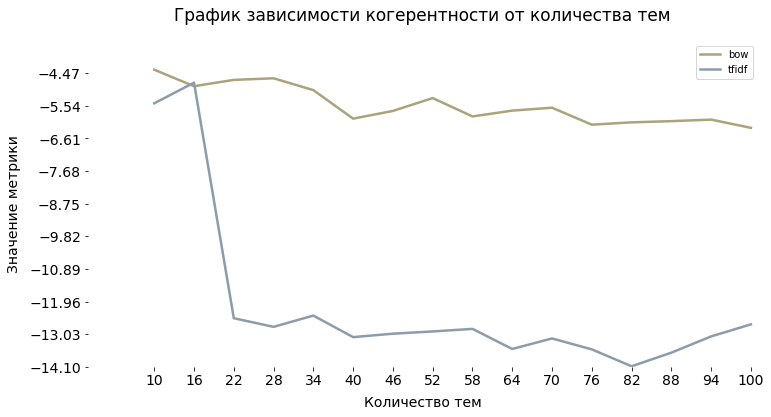

In [ ]:
visualize_metric(nums_topics, [scores['bow']['coh'], scores['tfidf']['coh']], 
                 title='График зависимости когерентности от количества тем', 
                 labels=['bow', 'tfidf'], xlabel = 'Количество тем', ylabel='Значение метрики')

При интерпретации внешних мтерик моделей обучения без учителя принято обращать внимание на такие значения аргумента, при которых функция перестает значимо изменяться -- по-простому, "локоть" графика. То есть, зачастую само по себе значение критерия качества не совпадает с мнением эксперта, вручную изучившего результаты работы моделей; а важной оказывается момент, когда наступает стабильность. <br>
Несмотря на то что показатели моделей обученных на BoW превышают те же на TF-IDf, для последней мы можем точно выделить оптимальное значение количества тем. Стабильность первой даже интересна, и сама по себе представляет повод для изучения -- это значит, что в целом, для метрики, которая славится тем, как она хорошо и человекоподобно оценивает интерпретируемость тем, не различаются темы, полученные в количесте 10 и 100 штук. Вывод: выигрывает TF-IDF векторизация.

### TF-IDF когерентность

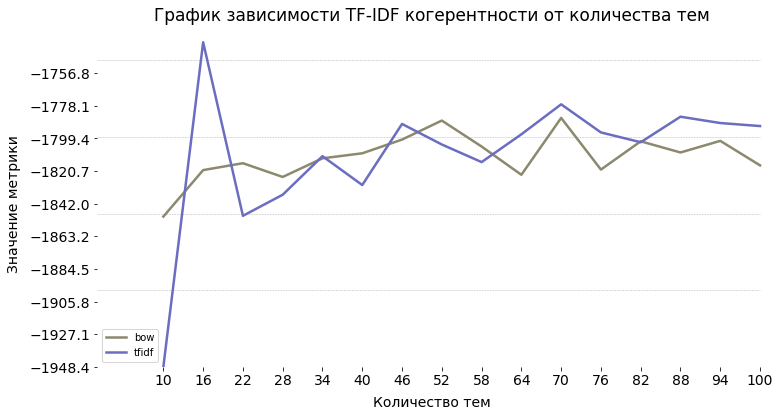

In [ ]:
visualize_metric(nums_topics, [scores['bow']['tfidf'], scores['tfidf']['tfidf']], 
                 title='График зависимости TF-IDF когерентности от количества тем', 
                 labels=['bow', 'tfidf'], xlabel = 'Количество тем', ylabel='Значение метрики')

Вслед за авторами статьи, откуда взята метрика, будем считать, что она прямо пропорциональна интерертируемости тем, а в следствие, модели. Видим, что начиная примерно с 22 значения для TF-IDF и BoW модели fluctuate в общем промежутке, что, кажется, хорошо говорит о метрике -- она позволяет найти подходящие количество тем вне зависимости от способа векторизации.
<br>
Сравнивая способы векторизации, снова отмечаем стабильность Bow, и легко заметный "локоть" TF-IDF. Хоть авторы стать и указывают на то что более высокое значение метрики говорит о лушей модели, it doesn't seem to be the case в случае нашего корпуса: BoW имеет три примерно одинаковых пика (52, 70, 94), причем все находятся во второй половине распределения тем, что многовато для корпуса размером 3000 документов. Для TF-IDF бросающееся в глаза пиковое значение (16 тем), хоть и совпадает с ожиданиями для небольшого корпуса, явно является выбросом. Однако если снова считать "хорошим" значение, при котором функция стабилизируется (локоть), удобным будет использование TF-IDF метода векторизации.

### Перплексия

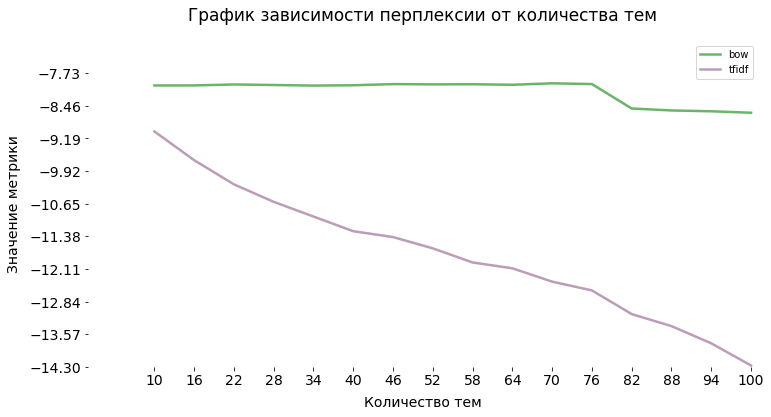

In [ ]:
visualize_metric(nums_topics, [scores['bow']['perp'], scores['tfidf']['perp']], 
                 title='График зависимости перплексии от количества тем', 
                 labels=['bow', 'tfidf'], xlabel = 'Количество тем', ylabel='Значение метрики')

Значение перплексии показывает, насколько модель будет "удивлена" при получении новых данных, насколько она неустойчива. Чем выше значение перплексии, тем лучше. На графике видим, что перплексиц TF-IDF модели равномерно падет, в то время как BoW - стабильно, за исключением небольшого снижение на уровне 76 тем.<br> Снова напрашивается мысль о том, что, видимо, для второй модели нет различия между темами, если их количество равно 10 и 100, что настораживает.
<br>
Что касается TF-IDF, можно предположить, что результаты этого способа объясняются тем, что вектора текстов и веса слов в нем сильно зависят друг от друга, поэтому любое изменение всей системы имеет большое влияние на модель в целом.